# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assessment against the original mixed and isolated signals.

In [2]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime
import soundfile as sf

import audio_functions as af
import audio_models
import dataset

In [3]:
importlib.reload(mf)

NameError: name 'mf' is not defined

### Get the variables and data ready

In [34]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
data_type = 'mag_phase'
phase_weight = 0.05
phase_loss_masking = True
phase_loss_approximation = True

checkpoint = '229/229-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/MagPhaseMask/checkpoints'
#model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Voice'
#directory_c = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Background'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type in ['mag_real_imag', 'mag_phase2']:
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)
elif data_type in ['mag_phase_real_imag', 'complex_to_mag_phase']:
    mixed_input = mixed_spec[:, :, :-1, :]
    voice_input = voice_spec[:, :, :-1, :]
    
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [35]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, is_training, learning_rate, 
                                    data_type, phase_weight, phase_loss_masking, phase_loss_approximation, 
                                    name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [18]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/229/229-8


### Run a batch

In [37]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, \
mask, voice_wave, mix_wave, background_wave = sess.run([model.mixed_input, 
                                                        model.mixed_phase, 
                                                        model.voice_input,
                                                        model.gen_voice, 
                                                        model.voice_mask, 
                                                        model.voice_audio, 
                                                        model.mixed_audio,
                                                        model.background_audio],
                                                       {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)


In [38]:
# Infer the estimated background noise by subtracting estimated voice from mixed signal

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = af.normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = af.normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = af.normalise_audio(mix_wave[i,:,:])
    background_wave[i,:,:] = af.normalise_audio(background_wave[i,:,:])

bg_est_wave = mix_wave - voice_est_wave

# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], background_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[10.9452511  12.39754848]] 
SIR
 [[16.40123719 17.0092915 ]] 
SAR
 [[12.4987652  14.32606525]] 
NSDR
 [[7.81397716 8.61788603]]


### Waveform and Mask Comparisons

The following set of cells were used to create the figure entitled "Waveform and Mask Comparisons" in the project report. For each of the next four cells, the network identified by the experiment ID provided was loaded using the cells above and a sample output stored. When the four samples were ready the fifth cell was run to roduce the figure.

In [11]:
#234
unet_out = voice_est_wave
unet_mask = mask
unet_sdr = round(sdrs[0][0], 3)

In [18]:
#279
capsunet_out = voice_est_wave
capsunet_mask = mask
capsunet_sdr = round(sdrs[0][0], 3)

In [24]:
#284
basic_conv_out = voice_est_wave
basic_conv_mask = mask
basic_conv_sdr = round(sdrs[0][0], 3)

In [30]:
#266
basic_caps_out = voice_est_wave
basic_caps_mask = mask
basic_caps_sdr = round(sdrs[0][0], 3)

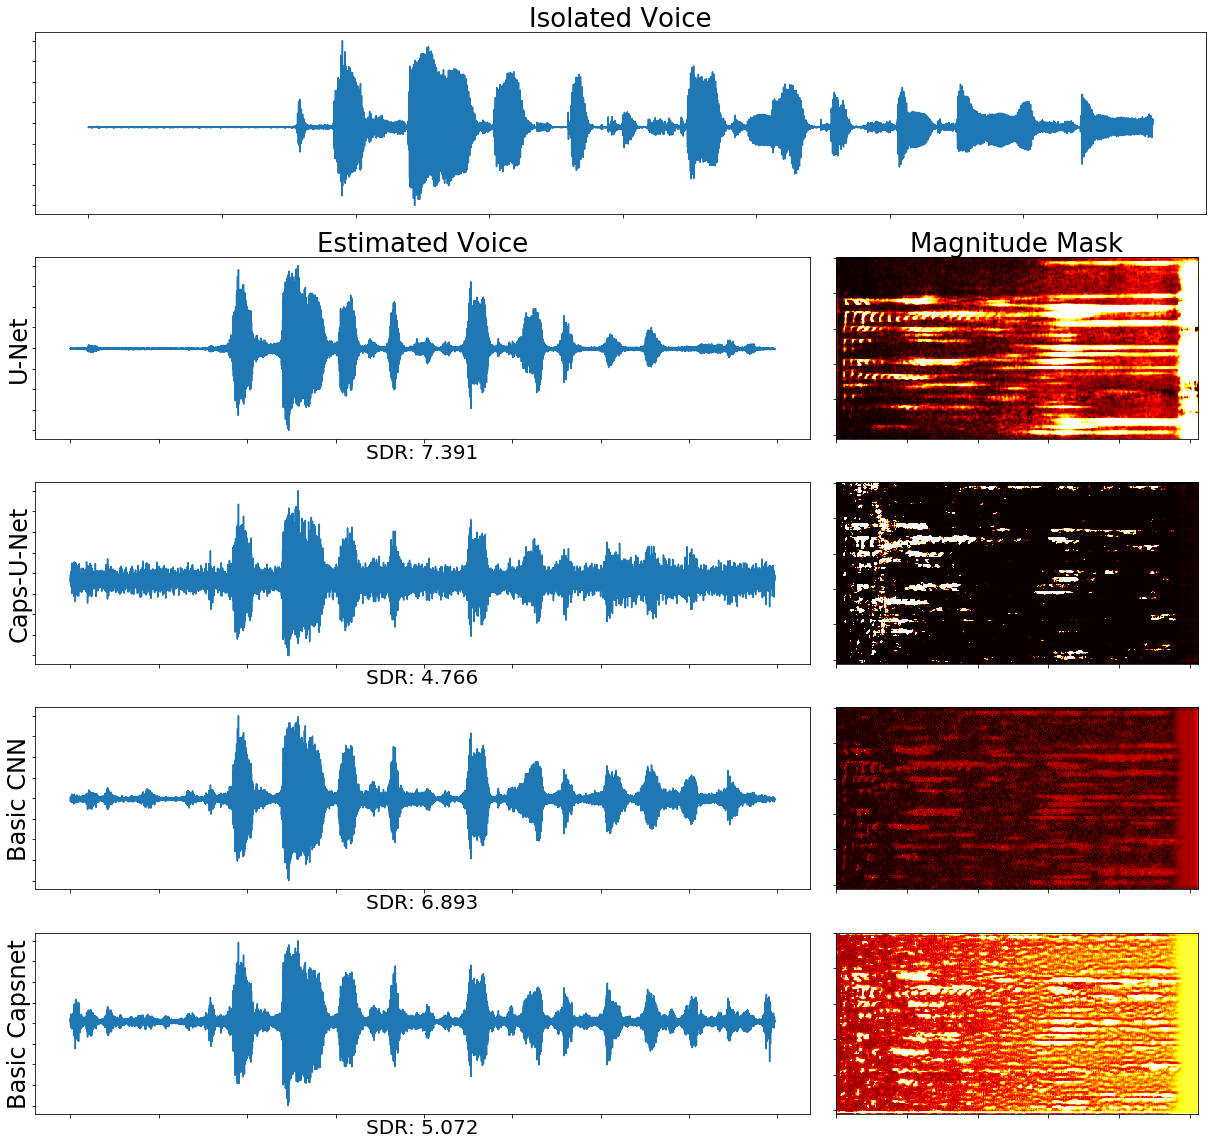

In [31]:
figs_folder = '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/Notebooks/Figures'
i=0
x = np.array(range(len(voice_wave[i])))/sample_rate

plt.figure(figsize=(17,16))
ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((5, 3), (1, 0), colspan=2)
ax3 = plt.subplot2grid((5, 3), (1, 2), colspan=3)
ax4 = plt.subplot2grid((5, 3), (2, 0), colspan=2)
ax5 = plt.subplot2grid((5, 3), (2, 2), colspan=3)
ax6 = plt.subplot2grid((5, 3), (3, 0), colspan=2)
ax7 = plt.subplot2grid((5, 3), (3, 2), colspan=3)
ax8 = plt.subplot2grid((5, 3), (4, 0), colspan=2)
ax9 = plt.subplot2grid((5, 3), (4, 2), colspan=3)

ax1.plot(x,voice_wave[i])
ax1.set_title('Isolated Voice', fontsize=26)
ax2.plot(x,unet_out[i])
ax2.set_title('Estimated Voice', fontsize=26)
ax2.set_xlabel('SDR: {i}'.format(i=unet_sdr), fontsize=20)
ax2.set_ylabel('U-Net', fontsize=24)
ax3.imshow(unet_mask[i,:,:,0])
ax3.set_title('Magnitude Mask', fontsize=26)
ax4.plot(x,capsunet_out[i])
ax4.set_xlabel('SDR: {i}'.format(i=capsunet_sdr), fontsize=20)
ax4.set_ylabel('Caps-U-Net', fontsize=24)
ax5.imshow(capsunet_mask[i,:,:,0])
ax6.plot(x,basic_conv_out[i])
ax6.set_xlabel('SDR: {i}'.format(i=basic_conv_sdr), fontsize=20)
ax6.set_ylabel('Basic CNN', fontsize=24)
ax7.imshow(basic_conv_mask[i,:,:,0])
ax8.plot(x,basic_caps_out[i])
ax8.set_xlabel('SDR: {i}'.format(i=basic_caps_sdr), fontsize=20)
ax8.set_ylabel('Basic Capsnet', fontsize=24)
ax9.imshow(basic_caps_mask[i,:,:,0])

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    plt.setp(ax.get_xticklabels(), visible=False)
    # The y-ticks will overlap with "hspace=0", so we'll hide the bottom tick
    plt.setp(ax.get_yticklabels(), visible=False)

plt.tight_layout()
plt.savefig(os.path.join(figs_folder, 'waveform_and_mask_comparisons_2.png'), bbox_inches='tight')
plt.show()

### Visualise and Listen to the network output

The output will consist of up to [batch_size] clips from a single recording.

In [39]:
i=0
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

1
65280


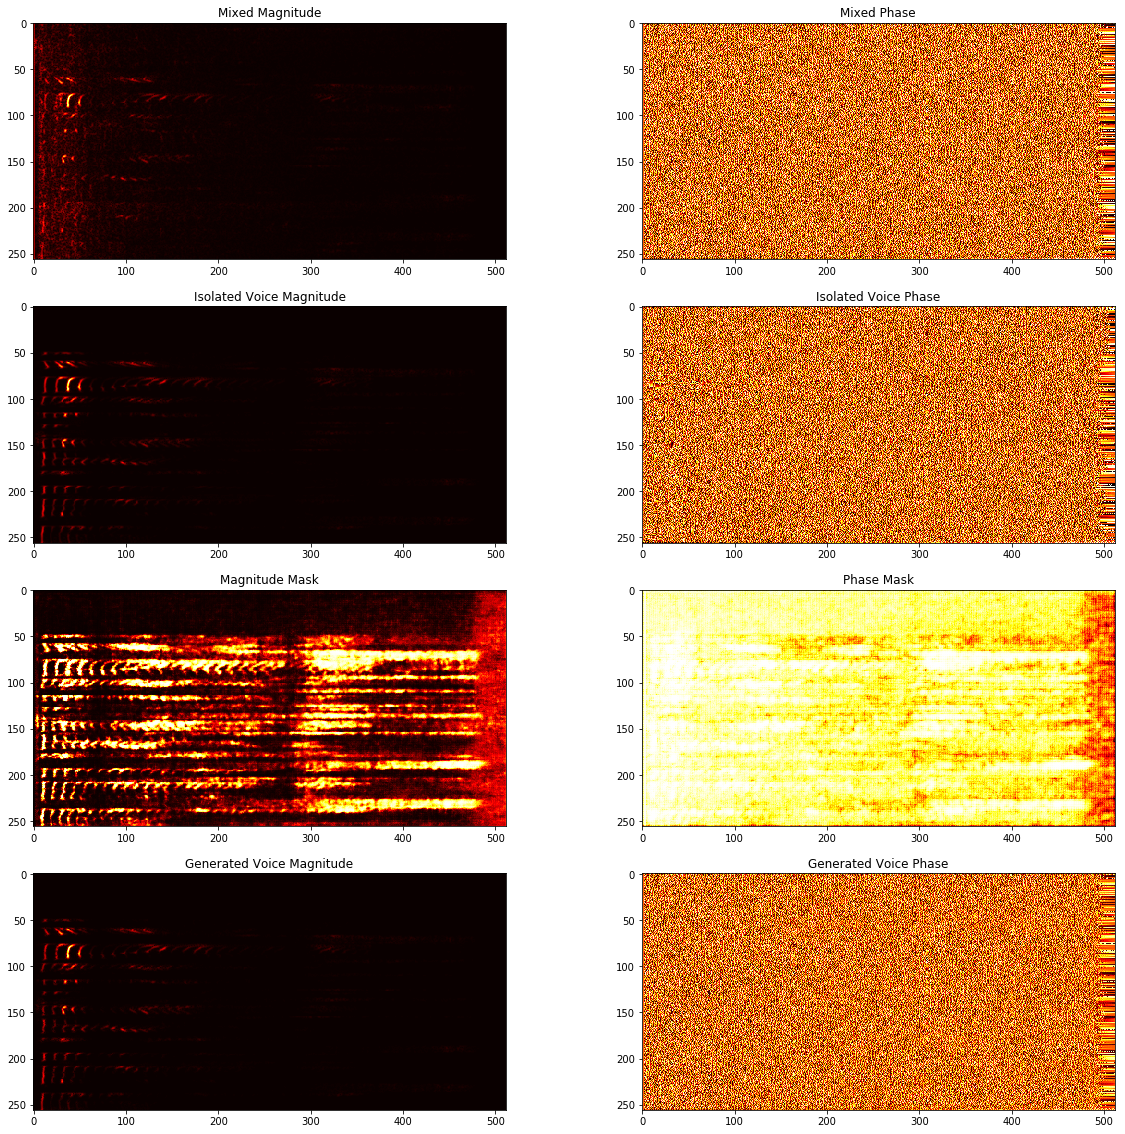

In [40]:
# Plot input and outputs for a magnitude and phase model
i=0

fig, ax = plt.subplots(4,2, figsize=(20,20))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('Mixed Magnitude')
ax[0,1].imshow(mix_inp[i,:,:,1])
ax[0,1].set_title('Mixed Phase')
ax[1,0].imshow(voice_inp[i,:,:,0])
ax[1,0].set_title('Isolated Voice Magnitude')
ax[1,1].imshow(voice_inp[i,:,:,1])
ax[1,1].set_title('Isolated Voice Phase')
ax[2,0].imshow(mask[i,:,:,0])
ax[2,0].set_title('Magnitude Mask')
ax[2,1].imshow(mask[i,:,:,1])
ax[2,1].set_title('Phase Mask')
ax[3,0].imshow(voice_est[i,:,:,0])
ax[3,0].set_title('Generated Voice Magnitude')
ax[3,1].imshow(voice_est[i,:,:,1])
ax[3,1].set_title('Generated Voice Phase')
#plt.savefig(os.path.join(folder, 'mag_phase_example_2.png'))
plt.show()

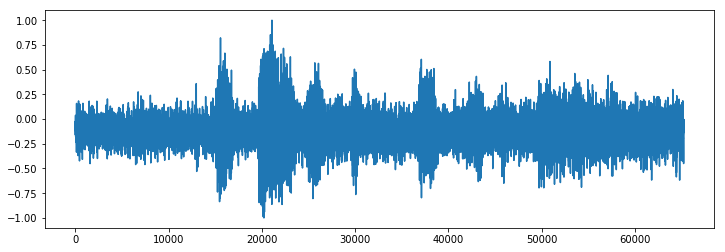

In [11]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

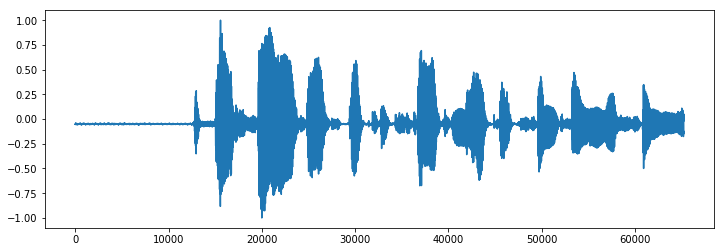

In [12]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

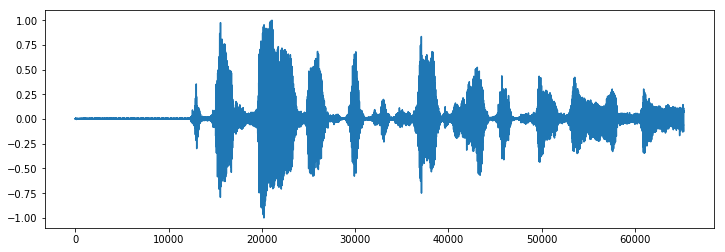

In [41]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

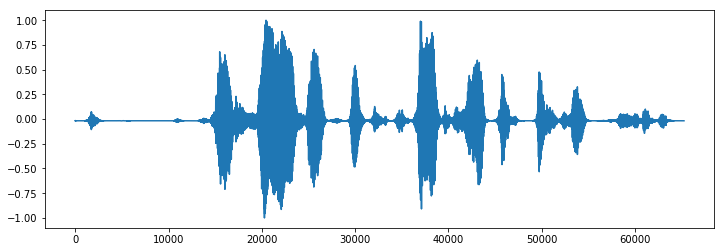

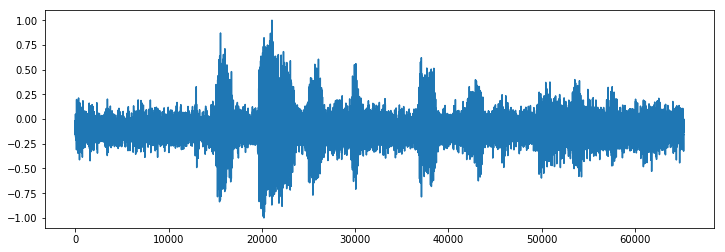

In [90]:
# Save an audio file
folder = 'audio_examples'
sf.write(os.path.join(folder,'mix_example_1.wav'), mix_wave[i], sample_rate)

The cell below is used to overfit a model to a tiny data set, in order to test its basic ability to learn.

In [ ]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 1000
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        #_, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        _, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.now(), c=cost))
        epoch_cost.append(cost)
        epoch_m_loss.append(m_loss)
        epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        #print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
                                                                               empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

In [36]:
# With new loss and masking - NSDR: 7.8, SAR: 12.5

start: 2019-02-22 13:26:54.436189
Iteration 0: 2019-02-22 13:26:55.537921
Cost: 0.004062278661876917
	Mean magnitude loss = 0.007530761882662773
	Mean phase loss = 0.0005937954410910606
Iteration 1: 2019-02-22 13:26:55.669088
Cost: 0.0040306635200977325
	Mean magnitude loss = 0.007502732565626502
	Mean phase loss = 0.0005902094708289951
Iteration 2: 2019-02-22 13:26:55.795943
Cost: 0.003996537532657385
	Mean magnitude loss = 0.007472997065633535
	Mean phase loss = 0.0005866561162595948
Iteration 3: 2019-02-22 13:26:55.925272
Cost: 0.003962361719459295
	Mean magnitude loss = 0.007442906266078353
	Mean phase loss = 0.000583014523726888
Iteration 4: 2019-02-22 13:26:56.065709
Cost: 0.003928768914192915
	Mean magnitude loss = 0.007412767596542835
	Mean phase loss = 0.0005794765311293304
Iteration 5: 2019-02-22 13:26:56.209767
Cost: 0.0038933423347771168
	Mean magnitude loss = 0.007382264516005914
	Mean phase loss = 0.0005757196728760997
Iteration 6: 2019-02-22 13:26:56.334084
Cost: 0.00385

Iteration 54: 2019-02-22 13:27:02.599478
Cost: 0.001713379635475576
	Mean magnitude loss = 0.005265840405428952
	Mean phase loss = 0.00037481273122301153
Iteration 55: 2019-02-22 13:27:02.731755
Cost: 0.0016980748623609543
	Mean magnitude loss = 0.005228363409904497
	Mean phase loss = 0.0003722093091969977
Iteration 56: 2019-02-22 13:27:02.867893
Cost: 0.001671421341598034
	Mean magnitude loss = 0.005191440359084753
	Mean phase loss = 0.00036952306088591157
Iteration 57: 2019-02-22 13:27:03.002388
Cost: 0.0016473215073347092
	Mean magnitude loss = 0.0051549053269213645
	Mean phase loss = 0.00036698360179735607
Iteration 58: 2019-02-22 13:27:03.133490
Cost: 0.0016233663773164153
	Mean magnitude loss = 0.005118885211709698
	Mean phase loss = 0.000364441746476864
Iteration 59: 2019-02-22 13:27:03.263400
Cost: 0.0016024115029722452
	Mean magnitude loss = 0.005083398179461559
	Mean phase loss = 0.00036195371358189733
Iteration 60: 2019-02-22 13:27:03.396235
Cost: 0.0015840940177440643
	Mean

Iteration 108: 2019-02-22 13:27:09.725688
Cost: 0.001111906487494707
	Mean magnitude loss = 0.0038858279842165634
	Mean phase loss = 0.0002813766868795704
Iteration 109: 2019-02-22 13:27:09.860169
Cost: 0.0011103377910330892
	Mean magnitude loss = 0.0038692748385735533
	Mean phase loss = 0.00028023411286994817
Iteration 110: 2019-02-22 13:27:09.992682
Cost: 0.0011092890053987503
	Mean magnitude loss = 0.003852904728101986
	Mean phase loss = 0.00027920844870816646
Iteration 111: 2019-02-22 13:27:10.135452
Cost: 0.001093755243346095
	Mean magnitude loss = 0.0038366220687748864
	Mean phase loss = 0.0002781285850557781
Iteration 112: 2019-02-22 13:27:10.263246
Cost: 0.001089337863959372
	Mean magnitude loss = 0.0038205441664409846
	Mean phase loss = 0.00027707308160957047
Iteration 113: 2019-02-22 13:27:10.403337
Cost: 0.0010856055887416005
	Mean magnitude loss = 0.003804649669562646
	Mean phase loss = 0.00027606927949563485
Iteration 114: 2019-02-22 13:27:10.544291
Cost: 0.001086891163140

Iteration 162: 2019-02-22 13:27:16.975266
Cost: 0.0009113636333495378
	Mean magnitude loss = 0.003209823991052029
	Mean phase loss = 0.00023769203438123607
Iteration 163: 2019-02-22 13:27:17.113686
Cost: 0.0009255885379388928
	Mean magnitude loss = 0.003200641501036177
	Mean phase loss = 0.0002371407505806263
Iteration 164: 2019-02-22 13:27:17.251447
Cost: 0.0009272912866435945
	Mean magnitude loss = 0.00319168091765746
	Mean phase loss = 0.0002365061845700962
Iteration 165: 2019-02-22 13:27:17.390235
Cost: 0.0009225747780874372
	Mean magnitude loss = 0.003182686950887991
	Mean phase loss = 0.00023596378022956336
Iteration 166: 2019-02-22 13:27:17.528774
Cost: 0.0008993280935101211
	Mean magnitude loss = 0.003173572875693173
	Mean phase loss = 0.00023537728929206238
Iteration 167: 2019-02-22 13:27:17.661310
Cost: 0.0009064601035788655
	Mean magnitude loss = 0.003164676936908758
	Mean phase loss = 0.00023477304966945667
Iteration 168: 2019-02-22 13:27:17.797646
Cost: 0.00091281061759218

Iteration 216: 2019-02-22 13:27:24.187127
Cost: 0.0008083678549155593
	Mean magnitude loss = 0.0028053030107719696
	Mean phase loss = 0.00021196738783267973
Iteration 217: 2019-02-22 13:27:24.323208
Cost: 0.0008087126770988107
	Mean magnitude loss = 0.00279926772949226
	Mean phase loss = 0.0002115813616359897
Iteration 218: 2019-02-22 13:27:24.449581
Cost: 0.0008079589460976422
	Mean magnitude loss = 0.002793267408607009
	Mean phase loss = 0.00021121213380055986
Iteration 219: 2019-02-22 13:27:24.580982
Cost: 0.0008045361028052866
	Mean magnitude loss = 0.0027873084562915294
	Mean phase loss = 0.00021082832562652502
Iteration 220: 2019-02-22 13:27:24.735310
Cost: 0.0008059470565058291
	Mean magnitude loss = 0.002781395955807719
	Mean phase loss = 0.0002104682347824696
Iteration 221: 2019-02-22 13:27:24.857961
Cost: 0.0008011741447262466
	Mean magnitude loss = 0.00277551742132149
	Mean phase loss = 0.0002100876886329429
Iteration 222: 2019-02-22 13:27:24.993299
Cost: 0.00080161943333223

Iteration 270: 2019-02-22 13:27:31.453599
Cost: 0.0007425847579725087
	Mean magnitude loss = 0.002531325917113641
	Mean phase loss = 0.0001948631130269732
Iteration 271: 2019-02-22 13:27:31.584399
Cost: 0.0007473659934476018
	Mean magnitude loss = 0.002527049229898052
	Mean phase loss = 0.00019461238453539621
Iteration 272: 2019-02-22 13:27:31.733822
Cost: 0.0007662826683372259
	Mean magnitude loss = 0.0025229792885871215
	Mean phase loss = 0.00019432666161201635
Iteration 273: 2019-02-22 13:27:31.865981
Cost: 0.0007765883929096162
	Mean magnitude loss = 0.002518955647459349
	Mean phase loss = 0.00019410165615446091
Iteration 274: 2019-02-22 13:27:32.004032
Cost: 0.0007435320876538754
	Mean magnitude loss = 0.002514770888215439
	Mean phase loss = 0.00019382825843587687
Iteration 275: 2019-02-22 13:27:32.145684
Cost: 0.000739886483643204
	Mean magnitude loss = 0.0025105757450691654
	Mean phase loss = 0.0001935711328163355
Iteration 276: 2019-02-22 13:27:32.284408
Cost: 0.000739057490136

Iteration 324: 2019-02-22 13:27:38.697491
Cost: 0.0007104615215212107
	Mean magnitude loss = 0.002331977028829547
	Mean phase loss = 0.00018268414974535028
Iteration 325: 2019-02-22 13:27:38.833202
Cost: 0.0007019253680482507
	Mean magnitude loss = 0.0023287721249657723
	Mean phase loss = 0.00018248165961379253
Iteration 326: 2019-02-22 13:27:38.961234
Cost: 0.0007029981934465468
	Mean magnitude loss = 0.00232557731748926
	Mean phase loss = 0.00018229647491494654
Iteration 327: 2019-02-22 13:27:39.095616
Cost: 0.0007006014348007739
	Mean magnitude loss = 0.002322403513173368
	Mean phase loss = 0.00018209628258152472
Iteration 328: 2019-02-22 13:27:39.231074
Cost: 0.0007063678349368274
	Mean magnitude loss = 0.002319263255062278
	Mean phase loss = 0.00018191810883174715
Iteration 329: 2019-02-22 13:27:39.373472
Cost: 0.0007041275384835899
	Mean magnitude loss = 0.002316151757964469
	Mean phase loss = 0.00018171770802423865
Iteration 330: 2019-02-22 13:27:39.504866
Cost: 0.00070426717866

Iteration 378: 2019-02-22 13:27:45.879178
Cost: 0.0006684953696094453
	Mean magnitude loss = 0.00217891173863582
	Mean phase loss = 0.00017355677111078628
Iteration 379: 2019-02-22 13:27:46.013856
Cost: 0.0006733800400979817
	Mean magnitude loss = 0.0021764146375445356
	Mean phase loss = 0.00017340727112911592
Iteration 380: 2019-02-22 13:27:46.148994
Cost: 0.0006719086086377501
	Mean magnitude loss = 0.0021739176714675517
	Mean phase loss = 0.0001732638048306303
Iteration 381: 2019-02-22 13:27:46.288321
Cost: 0.0006713911425322294
	Mean magnitude loss = 0.0021714329687849234
	Mean phase loss = 0.00017311919039204906
Iteration 382: 2019-02-22 13:27:46.426692
Cost: 0.0006695394986309111
	Mean magnitude loss = 0.0021689539001987124
	Mean phase loss = 0.00017297300268083145
Iteration 383: 2019-02-22 13:27:46.564910
Cost: 0.0006682114908471704
	Mean magnitude loss = 0.0021664792905842964
	Mean phase loss = 0.00017282911253838998
Iteration 384: 2019-02-22 13:27:46.697555
Cost: 0.00066364998

Iteration 432: 2019-02-22 13:27:53.127037
Cost: 0.0006420721183530986
	Mean magnitude loss = 0.0020574354999494367
	Mean phase loss = 0.0001665118804946757
Iteration 433: 2019-02-22 13:27:53.255691
Cost: 0.0006457796553149819
	Mean magnitude loss = 0.0020553978087062934
	Mean phase loss = 0.00016640121207965757
Iteration 434: 2019-02-22 13:27:53.392601
Cost: 0.0006502401665784419
	Mean magnitude loss = 0.0020534027844196423
	Mean phase loss = 0.00016627826232158032
Iteration 435: 2019-02-22 13:27:53.534955
Cost: 0.0006588176474906504
	Mean magnitude loss = 0.00205143585501008
	Mean phase loss = 0.00016617627957327946
Iteration 436: 2019-02-22 13:27:53.668367
Cost: 0.0006542708142660558
	Mean magnitude loss = 0.0020494805438469594
	Mean phase loss = 0.00016605133791209052
Iteration 437: 2019-02-22 13:27:53.802385
Cost: 0.0006508679944090545
	Mean magnitude loss = 0.0020475000500270765
	Mean phase loss = 0.00016594553985523983
Iteration 438: 2019-02-22 13:27:53.937242
Cost: 0.00064005068

Iteration 486: 2019-02-22 13:28:00.362887
Cost: 0.0006275352789089084
	Mean magnitude loss = 0.0019582834807597483
	Mean phase loss = 0.0001609190661636816
Iteration 487: 2019-02-22 13:28:00.492208
Cost: 0.000626648310571909
	Mean magnitude loss = 0.0019565999856672907
	Mean phase loss = 0.0001608281638225174
Iteration 488: 2019-02-22 13:28:00.623253
Cost: 0.0006259527872316539
	Mean magnitude loss = 0.001954926027162172
	Mean phase loss = 0.00016073213751163098
Iteration 489: 2019-02-22 13:28:00.767602
Cost: 0.0006355188088491559
	Mean magnitude loss = 0.0019532852742003694
	Mean phase loss = 0.0001606491751159893
Iteration 490: 2019-02-22 13:28:00.886198
Cost: 0.0006400616839528084
	Mean magnitude loss = 0.0019516891369770629
	Mean phase loss = 0.00016054712288267057
Iteration 491: 2019-02-22 13:28:01.022808
Cost: 0.0006438445416279137
	Mean magnitude loss = 0.0019500932225113266
	Mean phase loss = 0.0001604671285563902
Iteration 492: 2019-02-22 13:28:01.149959
Cost: 0.00062309409258

Iteration 540: 2019-02-22 13:28:07.600149
Cost: 0.0006081410683691502
	Mean magnitude loss = 0.0018753411713987589
	Mean phase loss = 0.0001563906401092171
Iteration 541: 2019-02-22 13:28:07.743638
Cost: 0.000611365307122469
	Mean magnitude loss = 0.001873921782742306
	Mean phase loss = 0.0001563174067244683
Iteration 542: 2019-02-22 13:28:07.881998
Cost: 0.0006098661106079817
	Mean magnitude loss = 0.0018725089167551743
	Mean phase loss = 0.00015623762628083285
Iteration 543: 2019-02-22 13:28:08.036969
Cost: 0.000612782605458051
	Mean magnitude loss = 0.0018711028999806492
	Mean phase loss = 0.000156167206742954
Iteration 544: 2019-02-22 13:28:08.178201
Cost: 0.0006094251293689013
	Mean magnitude loss = 0.0018696996637560222
	Mean phase loss = 0.00015608710373021285
Iteration 545: 2019-02-22 13:28:08.298121
Cost: 0.0006148755201138556
	Mean magnitude loss = 0.0018683105279459539
	Mean phase loss = 0.0001560182986745181
Iteration 546: 2019-02-22 13:28:08.426594
Cost: 0.0006087397923693

Iteration 594: 2019-02-22 13:28:14.824879
Cost: 0.0005916245863772929
	Mean magnitude loss = 0.0018047274691013603
	Mean phase loss = 0.00015265417497794872
Iteration 595: 2019-02-22 13:28:14.964955
Cost: 0.0005963248549960554
	Mean magnitude loss = 0.0018035036044104663
	Mean phase loss = 0.00015259493242130042
Iteration 596: 2019-02-22 13:28:15.096802
Cost: 0.0005963158910162747
	Mean magnitude loss = 0.0018022924102374807
	Mean phase loss = 0.00015252728783340277
Iteration 597: 2019-02-22 13:28:15.230503
Cost: 0.0005975758540444076
	Mean magnitude loss = 0.0018010799065201128
	Mean phase loss = 0.00015246944382660602
Iteration 598: 2019-02-22 13:28:15.367543
Cost: 0.0005983653827570379
	Mean magnitude loss = 0.0017998835988473365
	Mean phase loss = 0.0001524022813956953
Iteration 599: 2019-02-22 13:28:15.509474
Cost: 0.0006008917698636651
	Mean magnitude loss = 0.0017986892893289525
	Mean phase loss = 0.0001523457536677597
Iteration 600: 2019-02-22 13:28:15.650521
Cost: 0.0005940722

Iteration 648: 2019-02-22 13:28:22.076666
Cost: 0.0005897704395465553
	Mean magnitude loss = 0.001743595820610542
	Mean phase loss = 0.00014952641682606407
Iteration 649: 2019-02-22 13:28:22.213591
Cost: 0.000593115808442235
	Mean magnitude loss = 0.0017425565340986045
	Mean phase loss = 0.00014947817938473936
Iteration 650: 2019-02-22 13:28:22.346659
Cost: 0.0005820281803607941
	Mean magnitude loss = 0.0017414941962453582
	Mean phase loss = 0.0001494222708533199
Iteration 651: 2019-02-22 13:28:22.470631
Cost: 0.0005810484872199595
	Mean magnitude loss = 0.0017404279968361342
	Mean phase loss = 0.00014937064903290111
Iteration 652: 2019-02-22 13:28:22.603789
Cost: 0.0005802916130051017
	Mean magnitude loss = 0.0017393661001882592
	Mean phase loss = 0.00014931582986586834
Iteration 653: 2019-02-22 13:28:22.724189
Cost: 0.000586818263400346
	Mean magnitude loss = 0.0017383227136202543
	Mean phase loss = 0.00014926587491656158
Iteration 654: 2019-02-22 13:28:22.860316
Cost: 0.000585191708

Iteration 702: 2019-02-22 13:28:29.294538
Cost: 0.0005732337012887001
	Mean magnitude loss = 0.0016898815071337444
	Mean phase loss = 0.00014687130596926885
Iteration 703: 2019-02-22 13:28:29.435966
Cost: 0.000580483116209507
	Mean magnitude loss = 0.0016889620454259618
	Mean phase loss = 0.0001468308436291078
Iteration 704: 2019-02-22 13:28:29.567507
Cost: 0.000574353791307658
	Mean magnitude loss = 0.001688037480802295
	Mean phase loss = 0.000146780819103703
Iteration 705: 2019-02-22 13:28:29.698526
Cost: 0.0005750214331783354
	Mean magnitude loss = 0.0016871083624431435
	Mean phase loss = 0.0001467400005881387
Iteration 706: 2019-02-22 13:28:29.815496
Cost: 0.0005729775875806808
	Mean magnitude loss = 0.0016861840945245669
	Mean phase loss = 0.00014669129375213246
Iteration 707: 2019-02-22 13:28:29.953570
Cost: 0.000574358506128192
	Mean magnitude loss = 0.0016852595467162503
	Mean phase loss = 0.00014664951610892925
Iteration 708: 2019-02-22 13:28:30.082137
Cost: 0.0005719012115150

Iteration 756: 2019-02-22 13:28:36.504706
Cost: 0.0005626444472000003
	Mean magnitude loss = 0.0016424932189241465
	Mean phase loss = 0.00014459254800897495
Iteration 757: 2019-02-22 13:28:36.629134
Cost: 0.0005663504707626998
	Mean magnitude loss = 0.0016416657384605415
	Mean phase loss = 0.00014455672392477576
Iteration 758: 2019-02-22 13:28:36.762046
Cost: 0.0005634294357150793
	Mean magnitude loss = 0.0016408400260076437
	Mean phase loss = 0.00014451370969180346
Iteration 759: 2019-02-22 13:28:36.895161
Cost: 0.0005698701133951545
	Mean magnitude loss = 0.0016400246383119865
	Mean phase loss = 0.00014447960585178073
Iteration 760: 2019-02-22 13:28:37.038883
Cost: 0.0005702640628442168
	Mean magnitude loss = 0.0016392227609515798
	Mean phase loss = 0.00014443525973315512
Iteration 761: 2019-02-22 13:28:37.173572
Cost: 0.0005732482532039285
	Mean magnitude loss = 0.0016384192156052985
	Mean phase loss = 0.00014440263510364526
Iteration 762: 2019-02-22 13:28:37.313108
Cost: 0.00056634

Iteration 810: 2019-02-22 13:28:43.740093
Cost: 0.0005565069150179625
	Mean magnitude loss = 0.0016000417628728597
	Mean phase loss = 0.0001426185678804647
Iteration 811: 2019-02-22 13:28:43.886575
Cost: 0.000560262706130743
	Mean magnitude loss = 0.0015993116769292782
	Mean phase loss = 0.00014258247781605139
Iteration 812: 2019-02-22 13:28:44.027072
Cost: 0.0005654229898937047
	Mean magnitude loss = 0.001598590292176289
	Mean phase loss = 0.0001425522657978746
Iteration 813: 2019-02-22 13:28:44.146970
Cost: 0.0005519904079847038
	Mean magnitude loss = 0.0015978450683535922
	Mean phase loss = 0.00014251473565564173
Iteration 814: 2019-02-22 13:28:44.266309
Cost: 0.0005530486232601106
	Mean magnitude loss = 0.0015970978507360706
	Mean phase loss = 0.0001424837170687984
Iteration 815: 2019-02-22 13:28:44.378652
Cost: 0.0005513338837772608
	Mean magnitude loss = 0.0015963533764542994
	Mean phase loss = 0.00014244765975044904
Iteration 816: 2019-02-22 13:28:44.508330
Cost: 0.0005536652170

Iteration 864: 2019-02-22 13:28:51.065460
Cost: 0.0005517496610991657
	Mean magnitude loss = 0.0015619032832557024
	Mean phase loss = 0.0001408867193187447
Iteration 865: 2019-02-22 13:28:51.195772
Cost: 0.0005624655168503523
	Mean magnitude loss = 0.0015612602586493403
	Mean phase loss = 0.0001408624702889938
Iteration 866: 2019-02-22 13:28:51.328835
Cost: 0.0005515060038305819
	Mean magnitude loss = 0.0015606038250762758
	Mean phase loss = 0.00014082788801072607
Iteration 867: 2019-02-22 13:28:51.477832
Cost: 0.0005464336136355996
	Mean magnitude loss = 0.0015599299635988132
	Mean phase loss = 0.00014080063839647425
Iteration 868: 2019-02-22 13:28:51.612243
Cost: 0.0005396719207055867
	Mean magnitude loss = 0.0015592471160175722
	Mean phase loss = 0.00014076842647293684
Iteration 869: 2019-02-22 13:28:51.751888
Cost: 0.0005417875945568085
	Mean magnitude loss = 0.0015585662093918085
	Mean phase loss = 0.00014074078101019815
Iteration 870: 2019-02-22 13:28:51.893750
Cost: 0.0005448434

Iteration 918: 2019-02-22 13:28:58.378925
Cost: 0.0005404722760431468
	Mean magnitude loss = 0.0015273368024339208
	Mean phase loss = 0.00013936615722700833
Iteration 919: 2019-02-22 13:28:58.523509
Cost: 0.0005428707809187472
	Mean magnitude loss = 0.001526733734594334
	Mean phase loss = 0.00013933774526262625
Iteration 920: 2019-02-22 13:28:58.645236
Cost: 0.0005425008130259812
	Mean magnitude loss = 0.0015261270935408545
	Mean phase loss = 0.000139313474462224
Iteration 921: 2019-02-22 13:28:58.783853
Cost: 0.0005341896321624517
	Mean magnitude loss = 0.001525507902046221
	Mean phase loss = 0.00013928509409921475
Iteration 922: 2019-02-22 13:28:58.915973
Cost: 0.0005367879057303071
	Mean magnitude loss = 0.0015248926953016048
	Mean phase loss = 0.0001392597621979665
Iteration 923: 2019-02-22 13:28:59.059062
Cost: 0.0005338902701623738
	Mean magnitude loss = 0.0015242745592339505
	Mean phase loss = 0.00013923247411283432
Iteration 924: 2019-02-22 13:28:59.200058
Cost: 0.0005348666454

Iteration 972: 2019-02-22 13:29:05.751600
Cost: 0.0005281690391711891
	Mean magnitude loss = 0.0014957155296382784
	Mean phase loss = 0.00013801299550713882
Iteration 973: 2019-02-22 13:29:05.888761
Cost: 0.0005271596019156277
	Mean magnitude loss = 0.0014951439789263052
	Mean phase loss = 0.00013798967011172987
Iteration 974: 2019-02-22 13:29:06.023702
Cost: 0.0005317021859809756
	Mean magnitude loss = 0.0014945823049101119
	Mean phase loss = 0.0001379670064078453
Iteration 975: 2019-02-22 13:29:06.156622
Cost: 0.0005317850736901164
	Mean magnitude loss = 0.001494023275822134
	Mean phase loss = 0.00013794306510060808
Iteration 976: 2019-02-22 13:29:06.287886
Cost: 0.0005318027106113732
	Mean magnitude loss = 0.001493466438672209
	Mean phase loss = 0.0001379181612440277
Iteration 977: 2019-02-22 13:29:06.428985
Cost: 0.0005380453658290207
	Mean magnitude loss = 0.0014929190018678042
	Mean phase loss = 0.00013789781292194333
Iteration 978: 2019-02-22 13:29:06.570491
Cost: 0.000529713055

In [29]:
# With new loss - NSDR = 7.7, SAR = 12.4

start: 2019-02-22 13:22:17.510624
Iteration 0: 2019-02-22 13:22:18.524819
Cost: 0.0039762998931109905
	Mean magnitude loss = 0.007377983536571264
	Mean phase loss = 0.0005746163660660386
Iteration 1: 2019-02-22 13:22:18.658519
Cost: 0.0039419266395270824
	Mean magnitude loss = 0.007347320672124624
	Mean phase loss = 0.0005709060933440924
Iteration 2: 2019-02-22 13:22:18.790395
Cost: 0.00390887213870883
	Mean magnitude loss = 0.007317511364817619
	Mean phase loss = 0.0005672212379674116
Iteration 3: 2019-02-22 13:22:18.920597
Cost: 0.003876602975651622
	Mean magnitude loss = 0.007288138614967465
	Mean phase loss = 0.0005637123686028644
Iteration 4: 2019-02-22 13:22:19.066007
Cost: 0.003842802718281746
	Mean magnitude loss = 0.0072584889829158785
	Mean phase loss = 0.0005601129378192127
Iteration 5: 2019-02-22 13:22:19.207704
Cost: 0.003804170759394765
	Mean magnitude loss = 0.007227100897580385
	Mean phase loss = 0.0005564575937266151
Iteration 6: 2019-02-22 13:22:19.344345
Cost: 0.0037

Iteration 54: 2019-02-22 13:22:25.645621
Cost: 0.001652165432460606
	Mean magnitude loss = 0.004963272509419105
	Mean phase loss = 0.0003481257209469649
Iteration 55: 2019-02-22 13:22:25.783444
Cost: 0.0016340261790901423
	Mean magnitude loss = 0.004929163846619693
	Mean phase loss = 0.0003457460646002021
Iteration 56: 2019-02-22 13:22:25.918582
Cost: 0.001616439432837069
	Mean magnitude loss = 0.004895718037069105
	Mean phase loss = 0.0003433667673226936
Iteration 57: 2019-02-22 13:22:26.026120
Cost: 0.0016018481692299247
	Mean magnitude loss = 0.004863037860245797
	Mean phase loss = 0.00034095403956096814
Iteration 58: 2019-02-22 13:22:26.159536
Cost: 0.0015857563121244311
	Mean magnitude loss = 0.004830841231554494
	Mean phase loss = 0.0003387018669716288
Iteration 59: 2019-02-22 13:22:26.295103
Cost: 0.0015684692189097404
	Mean magnitude loss = 0.00479917605019485
	Mean phase loss = 0.00033649030519882216
Iteration 60: 2019-02-22 13:22:26.419101
Cost: 0.0015572101110592484
	Mean ma

Iteration 108: 2019-02-22 13:22:32.687262
Cost: 0.0011671249521896243
	Mean magnitude loss = 0.0037564389757948733
	Mean phase loss = 0.00026584263178605345
Iteration 109: 2019-02-22 13:22:32.823177
Cost: 0.001160940621048212
	Mean magnitude loss = 0.00374192922714759
	Mean phase loss = 0.0002648941956894388
Iteration 110: 2019-02-22 13:22:32.956448
Cost: 0.0011573518859222531
	Mean magnitude loss = 0.003727621686233728
	Mean phase loss = 0.00026395741607867986
Iteration 111: 2019-02-22 13:22:33.096726
Cost: 0.001152441487647593
	Mean magnitude loss = 0.0037134896556381136
	Mean phase loss = 0.00026302966073542066
Iteration 112: 2019-02-22 13:22:33.228987
Cost: 0.0011440578382462263
	Mean magnitude loss = 0.003699462770162958
	Mean phase loss = 0.0002621149206925513
Iteration 113: 2019-02-22 13:22:33.352173
Cost: 0.0011438034707680345
	Mean magnitude loss = 0.0036856538469069882
	Mean phase loss = 0.00026123989051771596
Iteration 114: 2019-02-22 13:22:33.484272
Cost: 0.0011409709695726

Iteration 162: 2019-02-22 13:22:39.902433
Cost: 0.000994779751636088
	Mean magnitude loss = 0.0031676503088313834
	Mean phase loss = 0.00022776628370565344
Iteration 163: 2019-02-22 13:22:40.033312
Cost: 0.0009930277010425925
	Mean magnitude loss = 0.003159617095129428
	Mean phase loss = 0.00022720583170090188
Iteration 164: 2019-02-22 13:22:40.166771
Cost: 0.000982399214990437
	Mean magnitude loss = 0.003151498224134698
	Mean phase loss = 0.0002267063725880827
Iteration 165: 2019-02-22 13:22:40.294387
Cost: 0.0009751783218234777
	Mean magnitude loss = 0.0031434152168726705
	Mean phase loss = 0.00022618788641986875
Iteration 166: 2019-02-22 13:22:40.439221
Cost: 0.0009698568028397858
	Mean magnitude loss = 0.003135375168263734
	Mean phase loss = 0.00022566572246824888
Iteration 167: 2019-02-22 13:22:40.574729
Cost: 0.0009752611513249576
	Mean magnitude loss = 0.00312745627888944
	Mean phase loss = 0.00022518866786586366
Iteration 168: 2019-02-22 13:22:40.715058
Cost: 0.0009723903494887

Iteration 216: 2019-02-22 13:22:47.036906
Cost: 0.0008791321306489408
	Mean magnitude loss = 0.0028064872705793943
	Mean phase loss = 0.0002049002635468673
Iteration 217: 2019-02-22 13:22:47.169429
Cost: 0.0008884420385584235
	Mean magnitude loss = 0.002801132259181265
	Mean phase loss = 0.0002045924152507139
Iteration 218: 2019-02-22 13:22:47.307808
Cost: 0.0008834692998789251
	Mean magnitude loss = 0.0027958404232394886
	Mean phase loss = 0.0002042276937074398
Iteration 219: 2019-02-22 13:22:47.446894
Cost: 0.0008716121083125472
	Mean magnitude loss = 0.0027904511577534403
	Mean phase loss = 0.0002039040325722784
Iteration 220: 2019-02-22 13:22:47.577762
Cost: 0.0008683143532834947
	Mean magnitude loss = 0.0027850986615337464
	Mean phase loss = 0.00020356545892725298
Iteration 221: 2019-02-22 13:22:47.692195
Cost: 0.0008655970450490713
	Mean magnitude loss = 0.0027797593560011068
	Mean phase loss = 0.00020324048530604054
Iteration 222: 2019-02-22 13:22:47.828511
Cost: 0.0008634289843

Iteration 270: 2019-02-22 13:22:54.059352
Cost: 0.0008121453574858606
	Mean magnitude loss = 0.002557389727257522
	Mean phase loss = 0.0001894985376915214
Iteration 271: 2019-02-22 13:22:54.196649
Cost: 0.000810698140412569
	Mean magnitude loss = 0.0025534758901545394
	Mean phase loss = 0.0001892745364570788
Iteration 272: 2019-02-22 13:22:54.336825
Cost: 0.0008146616746671498
	Mean magnitude loss = 0.002549652274162423
	Mean phase loss = 0.00018901966495998886
Iteration 273: 2019-02-22 13:22:54.481318
Cost: 0.0008205429185181856
	Mean magnitude loss = 0.0025458586522051725
	Mean phase loss = 0.00018880749811727663
Iteration 274: 2019-02-22 13:22:54.607035
Cost: 0.0008090920164249837
	Mean magnitude loss = 0.002542047214440324
	Mean phase loss = 0.0001885590008301237
Iteration 275: 2019-02-22 13:22:54.739516
Cost: 0.0008022428373806179
	Mean magnitude loss = 0.0025381993036717176
	Mean phase loss = 0.0001883267648710002
Iteration 276: 2019-02-22 13:22:54.864537
Cost: 0.0007988904835656

Iteration 324: 2019-02-22 13:23:01.124176
Cost: 0.0007607803563587368
	Mean magnitude loss = 0.0023733476957736106
	Mean phase loss = 0.00017838939527372043
Iteration 325: 2019-02-22 13:23:01.262026
Cost: 0.0007586533320136368
	Mean magnitude loss = 0.0023703590825348633
	Mean phase loss = 0.0001782049090430809
Iteration 326: 2019-02-22 13:23:01.399915
Cost: 0.0007626066799275577
	Mean magnitude loss = 0.002367395872751462
	Mean phase loss = 0.00017803860632474862
Iteration 327: 2019-02-22 13:23:01.548632
Cost: 0.0007656100206077099
	Mean magnitude loss = 0.00236449354979857
	Mean phase loss = 0.00017784881224432002
Iteration 328: 2019-02-22 13:23:01.682022
Cost: 0.0007710541831329465
	Mean magnitude loss = 0.002361608857407849
	Mean phase loss = 0.00017769327990078767
Iteration 329: 2019-02-22 13:23:01.816790
Cost: 0.0007651313208043575
	Mean magnitude loss = 0.002358737131439601
	Mean phase loss = 0.00017750731060390756
Iteration 330: 2019-02-22 13:23:01.947639
Cost: 0.00075904186815

Iteration 378: 2019-02-22 13:23:08.206105
Cost: 0.0007306186598725617
	Mean magnitude loss = 0.00223014748097449
	Mean phase loss = 0.00016998826900231688
Iteration 379: 2019-02-22 13:23:08.331658
Cost: 0.0007244454463943839
	Mean magnitude loss = 0.00222778132791925
	Mean phase loss = 0.00016985114611758802
Iteration 380: 2019-02-22 13:23:08.461333
Cost: 0.0007239438127726316
	Mean magnitude loss = 0.0022254208471929153
	Mean phase loss = 0.0001697188583654877
Iteration 381: 2019-02-22 13:23:08.593176
Cost: 0.0007203675922937691
	Mean magnitude loss = 0.0022230620236326185
	Mean phase loss = 0.00016957924071426932
Iteration 382: 2019-02-22 13:23:08.726319
Cost: 0.0007201244588941336
	Mean magnitude loss = 0.0022207042263144767
	Mean phase loss = 0.0001694503738281959
Iteration 383: 2019-02-22 13:23:08.860331
Cost: 0.000726520549505949
	Mean magnitude loss = 0.002218407118562027
	Mean phase loss = 0.00016930708174337875
Iteration 384: 2019-02-22 13:23:08.996965
Cost: 0.0007367008947767

Iteration 432: 2019-02-22 13:23:15.347000
Cost: 0.000704476551618427
	Mean magnitude loss = 0.0021147432338605543
	Mean phase loss = 0.00016343180825447183
Iteration 433: 2019-02-22 13:23:15.478067
Cost: 0.0006976458244025707
	Mean magnitude loss = 0.0021128246704468392
	Mean phase loss = 0.00016331607808492014
Iteration 434: 2019-02-22 13:23:15.610191
Cost: 0.0006955955177545547
	Mean magnitude loss = 0.002110892000083608
	Mean phase loss = 0.00016321438129177724
Iteration 435: 2019-02-22 13:23:15.748033
Cost: 0.0006916808197274804
	Mean magnitude loss = 0.00210896068425644
	Mean phase loss = 0.00016310270464166876
Iteration 436: 2019-02-22 13:23:15.872716
Cost: 0.00069582206197083
	Mean magnitude loss = 0.0021070463042621003
	Mean phase loss = 0.00016300239519256613
Iteration 437: 2019-02-22 13:23:16.004024
Cost: 0.0006921566091477871
	Mean magnitude loss = 0.0021051369749911166
	Mean phase loss = 0.00016288949745389862
Iteration 438: 2019-02-22 13:23:16.134535
Cost: 0.00069711683318

Iteration 486: 2019-02-22 13:23:22.480133
Cost: 0.0006726404535584152
	Mean magnitude loss = 0.002019358866750521
	Mean phase loss = 0.00015817545238429074
Iteration 487: 2019-02-22 13:23:22.618763
Cost: 0.0006692181923426688
	Mean magnitude loss = 0.00201773091331964
	Mean phase loss = 0.00015808394293911034
Iteration 488: 2019-02-22 13:23:22.756831
Cost: 0.0006705567939206958
	Mean magnitude loss = 0.0020161076543608906
	Mean phase loss = 0.0001580002462494488
Iteration 489: 2019-02-22 13:23:22.893278
Cost: 0.0006675285985693336
	Mean magnitude loss = 0.00201448549597277
	Mean phase loss = 0.00015791005617404375
Iteration 490: 2019-02-22 13:23:23.021981
Cost: 0.00066649034852162
	Mean magnitude loss = 0.002012859962836985
	Mean phase loss = 0.00015782598685734012
Iteration 491: 2019-02-22 13:23:23.156326
Cost: 0.0006676097400486469
	Mean magnitude loss = 0.0020112496238993104
	Mean phase loss = 0.00015773822331805316
Iteration 492: 2019-02-22 13:23:23.281253
Cost: 0.00066769734257832

Iteration 540: 2019-02-22 13:23:29.613900
Cost: 0.0006504387129098177
	Mean magnitude loss = 0.00193874934789778
	Mean phase loss = 0.00015387638471375069
Iteration 541: 2019-02-22 13:23:29.745670
Cost: 0.0006537853623740375
	Mean magnitude loss = 0.0019373696570618017
	Mean phase loss = 0.00015380763456238712
Iteration 542: 2019-02-22 13:23:29.883124
Cost: 0.0006544661009684205
	Mean magnitude loss = 0.0019360067060004583
	Mean phase loss = 0.0001537299868246604
Iteration 543: 2019-02-22 13:23:30.025991
Cost: 0.0006623906083405018
	Mean magnitude loss = 0.0019346638206009042
	Mean phase loss = 0.00015366670400266338
Iteration 544: 2019-02-22 13:23:30.158201
Cost: 0.0006576497107744217
	Mean magnitude loss = 0.001933324464528454
	Mean phase loss = 0.00015358765438143506
Iteration 545: 2019-02-22 13:23:30.287530
Cost: 0.0006529063102789223
	Mean magnitude loss = 0.00193196005100937
	Mean phase loss = 0.00015352148277867985
Iteration 546: 2019-02-22 13:23:30.432123
Cost: 0.00064810912590

Iteration 594: 2019-02-22 13:23:36.695227
Cost: 0.0006332150660455227
	Mean magnitude loss = 0.0018693527727223496
	Mean phase loss = 0.00015030140229628007
Iteration 595: 2019-02-22 13:23:36.833425
Cost: 0.0006387372268363833
	Mean magnitude loss = 0.001868173401902786
	Mean phase loss = 0.00015023550521246401
Iteration 596: 2019-02-22 13:23:36.973182
Cost: 0.0006445685285143554
	Mean magnitude loss = 0.0018670044358120841
	Mean phase loss = 0.00015018291047618645
Iteration 597: 2019-02-22 13:23:37.104167
Cost: 0.0006380483973771334
	Mean magnitude loss = 0.0018658317254862458
	Mean phase loss = 0.00015011633896760653
Iteration 598: 2019-02-22 13:23:37.228437
Cost: 0.0006362583953887224
	Mean magnitude loss = 0.0018646467861117724
	Mean phase loss = 0.00015006015764841676
Iteration 599: 2019-02-22 13:23:37.364473
Cost: 0.0006289776065386832
	Mean magnitude loss = 0.001863446105659629
	Mean phase loss = 0.000149999585300975
Iteration 600: 2019-02-22 13:23:37.493012
Cost: 0.000629812770

Iteration 648: 2019-02-22 13:23:43.868377
Cost: 0.0006202983786351979
	Mean magnitude loss = 0.0018089572697783172
	Mean phase loss = 0.00014729174741234225
Iteration 649: 2019-02-22 13:23:43.995596
Cost: 0.0006156748859211802
	Mean magnitude loss = 0.001807893242042225
	Mean phase loss = 0.00014724054550662493
Iteration 650: 2019-02-22 13:23:44.131166
Cost: 0.0006174562149681151
	Mean magnitude loss = 0.0018068383724647596
	Mean phase loss = 0.00014718908426244909
Iteration 651: 2019-02-22 13:23:44.260100
Cost: 0.0006192567525431514
	Mean magnitude loss = 0.0018057909712375375
	Mean phase loss = 0.00014713907139761475
Iteration 652: 2019-02-22 13:23:44.392949
Cost: 0.00062026601517573
	Mean magnitude loss = 0.0018047523701914328
	Mean phase loss = 0.00014708671070974758
Iteration 653: 2019-02-22 13:23:44.526283
Cost: 0.0006224985118024051
	Mean magnitude loss = 0.001803720338962152
	Mean phase loss = 0.00014703794365290577
Iteration 654: 2019-02-22 13:23:44.653668
Cost: 0.000619728001

Iteration 702: 2019-02-22 13:23:50.976406
Cost: 0.0006178112234920263
	Mean magnitude loss = 0.00175571794291113
	Mean phase loss = 0.00014473190251895152
Iteration 703: 2019-02-22 13:23:51.104238
Cost: 0.0006076016579754651
	Mean magnitude loss = 0.0017547930988670983
	Mean phase loss = 0.00014468338504643313
Iteration 704: 2019-02-22 13:23:51.240952
Cost: 0.000607753754593432
	Mean magnitude loss = 0.0017538637667564108
	Mean phase loss = 0.00014464254836768164
Iteration 705: 2019-02-22 13:23:51.374762
Cost: 0.000604485918302089
	Mean magnitude loss = 0.0017529328752087466
	Mean phase loss = 0.00014459676220434292
Iteration 706: 2019-02-22 13:23:51.503366
Cost: 0.0006078117876313627
	Mean magnitude loss = 0.0017520093992668634
	Mean phase loss = 0.0001445557317242706
Iteration 707: 2019-02-22 13:23:51.641847
Cost: 0.0006063476321287453
	Mean magnitude loss = 0.001751090644097145
	Mean phase loss = 0.00014450856902367584
Iteration 708: 2019-02-22 13:23:51.773904
Cost: 0.00061063503380

Iteration 756: 2019-02-22 13:23:58.115176
Cost: 0.0005965880700387061
	Mean magnitude loss = 0.0017081746489210658
	Mean phase loss = 0.00014252439280256784
Iteration 757: 2019-02-22 13:23:58.241618
Cost: 0.0005943620344623923
	Mean magnitude loss = 0.0017073425099727916
	Mean phase loss = 0.0001424832138735715
Iteration 758: 2019-02-22 13:23:58.377646
Cost: 0.0005939528346061707
	Mean magnitude loss = 0.001706505728681843
	Mean phase loss = 0.0001424479002021198
Iteration 759: 2019-02-22 13:23:58.496211
Cost: 0.0005939291440881789
	Mean magnitude loss = 0.0017056770066693914
	Mean phase loss = 0.0001424067598954456
Iteration 760: 2019-02-22 13:23:58.626680
Cost: 0.0006122367340140045
	Mean magnitude loss = 0.0017048877316041215
	Mean phase loss = 0.00014237657330452028
Iteration 761: 2019-02-22 13:23:58.747098
Cost: 0.0006029801443219185
	Mean magnitude loss = 0.0017040897180018286
	Mean phase loss = 0.00014233298065309508
Iteration 762: 2019-02-22 13:23:58.883613
Cost: 0.000597707170

Iteration 810: 2019-02-22 13:24:05.319520
Cost: 0.00058055977569893
	Mean magnitude loss = 0.0016657005040647988
	Mean phase loss = 0.00014061114491918382
Iteration 811: 2019-02-22 13:24:05.452531
Cost: 0.0005861215176992118
	Mean magnitude loss = 0.0016649560815037636
	Mean phase loss = 0.0001405746948302711
Iteration 812: 2019-02-22 13:24:05.588452
Cost: 0.0005958008114248514
	Mean magnitude loss = 0.0016642286739200994
	Mean phase loss = 0.000140546962066392
Iteration 813: 2019-02-22 13:24:05.719633
Cost: 0.0005858215736225247
	Mean magnitude loss = 0.0016634879035689852
	Mean phase loss = 0.00014050992835046785
Iteration 814: 2019-02-22 13:24:05.867926
Cost: 0.000585816043894738
	Mean magnitude loss = 0.001662741442056704
	Mean phase loss = 0.00014048048103673875
Iteration 815: 2019-02-22 13:24:05.999245
Cost: 0.0005809005233459175
	Mean magnitude loss = 0.0016619902745850256
	Mean phase loss = 0.00014044559353066028
Iteration 816: 2019-02-22 13:24:06.137580
Cost: 0.000582120323088

Iteration 864: 2019-02-22 13:24:12.447932
Cost: 0.0005755573511123657
	Mean magnitude loss = 0.0016271032798077071
	Mean phase loss = 0.00013893861746694085
Iteration 865: 2019-02-22 13:24:12.566047
Cost: 0.0005742027424275875
	Mean magnitude loss = 0.0016264208823960817
	Mean phase loss = 0.0001389078088512044
Iteration 866: 2019-02-22 13:24:12.713324
Cost: 0.0005739658372476697
	Mean magnitude loss = 0.0016257364282464004
	Mean phase loss = 0.00013888015571512786
Iteration 867: 2019-02-22 13:24:12.846444
Cost: 0.0005711609264835715
	Mean magnitude loss = 0.0016250494486128714
	Mean phase loss = 0.000138850205993746
Iteration 868: 2019-02-22 13:24:12.987106
Cost: 0.00057654595002532
	Mean magnitude loss = 0.0016243735462817244
	Mean phase loss = 0.00013882322258999737
Iteration 869: 2019-02-22 13:24:13.107260
Cost: 0.0005770748248323798
	Mean magnitude loss = 0.001623705572625301
	Mean phase loss = 0.00013879114207804964
Iteration 870: 2019-02-22 13:24:13.250472
Cost: 0.00057987542822

Iteration 918: 2019-02-22 13:24:19.557497
Cost: 0.0005740858614444733
	Mean magnitude loss = 0.0015919803315165562
	Mean phase loss = 0.00013746564580127343
Iteration 919: 2019-02-22 13:24:19.687081
Cost: 0.0005657396395690739
	Mean magnitude loss = 0.001591357224717048
	Mean phase loss = 0.00013743878875096055
Iteration 920: 2019-02-22 13:24:19.820382
Cost: 0.0005660639726556838
	Mean magnitude loss = 0.0015907346917645971
	Mean phase loss = 0.00013741347359069427
Iteration 921: 2019-02-22 13:24:19.936761
Cost: 0.0005670604878105223
	Mean magnitude loss = 0.001590115221473843
	Mean phase loss = 0.00013738866278038305
Iteration 922: 2019-02-22 13:24:20.052514
Cost: 0.000567388255149126
	Mean magnitude loss = 0.0015894997890691554
	Mean phase loss = 0.0001373619203881299
Iteration 923: 2019-02-22 13:24:20.167139
Cost: 0.0005677514127455652
	Mean magnitude loss = 0.001588883814532955
	Mean phase loss = 0.00013733789618728022
Iteration 924: 2019-02-22 13:24:20.299738
Cost: 0.0005678246961

Iteration 972: 2019-02-22 13:24:26.726907
Cost: 0.0005570558132603765
	Mean magnitude loss = 0.0015598508428384043
	Mean phase loss = 0.0001361576943490908
Iteration 973: 2019-02-22 13:24:26.875371
Cost: 0.0005600274307653308
	Mean magnitude loss = 0.0015592793783448346
	Mean phase loss = 0.00013613783068585857
Iteration 974: 2019-02-22 13:24:27.023791
Cost: 0.0005627562641166151
	Mean magnitude loss = 0.0015587209028979907
	Mean phase loss = 0.00013611178856360942
Iteration 975: 2019-02-22 13:24:27.155830
Cost: 0.0005603033932857215
	Mean magnitude loss = 0.0015581524557554255
	Mean phase loss = 0.00013609188948469293
Iteration 976: 2019-02-22 13:24:27.285622
Cost: 0.0005527405301108956
	Mean magnitude loss = 0.0015575745330786022
	Mean phase loss = 0.00013606718848835955
Iteration 977: 2019-02-22 13:24:27.424964
Cost: 0.0005551189533434808
	Mean magnitude loss = 0.0015569983188544756
	Mean phase loss = 0.0001360468752944084
Iteration 978: 2019-02-22 13:24:27.556526
Cost: 0.0005628323

In [22]:
# The old way - NSDR = 7.2, SAR = 12.0

start: 2019-02-22 13:15:53.878323
Iteration 0: 2019-02-22 13:15:54.879666
Cost: 0.038514863699674606
	Mean magnitude loss = 0.007594256661832333
	Mean phase loss = 0.0694354698061943
Iteration 1: 2019-02-22 13:15:55.003367
Cost: 0.03842105343937874
	Mean magnitude loss = 0.007568828063085675
	Mean phase loss = 0.06936708837747574
Iteration 2: 2019-02-22 13:15:55.118278
Cost: 0.03832290694117546
	Mean magnitude loss = 0.007543284756441911
	Mean phase loss = 0.06929593036572139
Iteration 3: 2019-02-22 13:15:55.240138
Cost: 0.03823104873299599
	Mean magnitude loss = 0.007514965254813433
	Mean phase loss = 0.0692299697548151
Iteration 4: 2019-02-22 13:15:55.374895
Cost: 0.03813405707478523
	Mean magnitude loss = 0.0074889249168336395
	Mean phase loss = 0.06916064620018006
Iteration 5: 2019-02-22 13:15:55.507983
Cost: 0.0380493625998497
	Mean magnitude loss = 0.007463613447422783
	Mean phase loss = 0.0690941500167052
Iteration 6: 2019-02-22 13:15:55.625762
Cost: 0.037950560450553894
	Mean m

Iteration 56: 2019-02-22 13:16:02.159676
Cost: 0.034120749682188034
	Mean magnitude loss = 0.006030681224441842
	Mean phase loss = 0.06615225931531504
Iteration 57: 2019-02-22 13:16:02.299569
Cost: 0.03406773880124092
	Mean magnitude loss = 0.005999987647900808
	Mean phase loss = 0.06611316908022453
Iteration 58: 2019-02-22 13:16:02.427418
Cost: 0.03400200977921486
	Mean magnitude loss = 0.005969022534850796
	Mean phase loss = 0.06607448776899758
Iteration 59: 2019-02-22 13:16:02.561251
Cost: 0.03394821286201477
	Mean magnitude loss = 0.005938012703942756
	Mean phase loss = 0.06603637958566348
Iteration 60: 2019-02-22 13:16:02.695038
Cost: 0.03389471024274826
	Mean magnitude loss = 0.005907407343448674
	Mean phase loss = 0.06599837883574064
Iteration 61: 2019-02-22 13:16:02.828341
Cost: 0.033858783543109894
	Mean magnitude loss = 0.005876644642182415
	Mean phase loss = 0.06596158961615255
Iteration 62: 2019-02-22 13:16:02.961144
Cost: 0.033792272210121155
	Mean magnitude loss = 0.00584

Iteration 112: 2019-02-22 13:16:09.576276
Cost: 0.032265760004520416
	Mean magnitude loss = 0.004609188186499266
	Mean phase loss = 0.06453003645338844
Iteration 113: 2019-02-22 13:16:09.705322
Cost: 0.03223038092255592
	Mean magnitude loss = 0.004590618626312598
	Mean phase loss = 0.06450756684991352
Iteration 114: 2019-02-22 13:16:09.852275
Cost: 0.03221096098423004
	Mean magnitude loss = 0.0045723716424697115
	Mean phase loss = 0.06448515064042548
Iteration 115: 2019-02-22 13:16:09.970493
Cost: 0.032193925231695175
	Mean magnitude loss = 0.004554402894051424
	Mean phase loss = 0.06446286358324618
Iteration 116: 2019-02-22 13:16:10.100582
Cost: 0.03216980770230293
	Mean magnitude loss = 0.004536560046064676
	Mean phase loss = 0.06444072653340478
Iteration 117: 2019-02-22 13:16:10.233320
Cost: 0.03214827924966812
	Mean magnitude loss = 0.004518917736092235
	Mean phase loss = 0.06441870167598886
Iteration 118: 2019-02-22 13:16:10.369859
Cost: 0.03213378041982651
	Mean magnitude loss = 

Iteration 168: 2019-02-22 13:16:16.974365
Cost: 0.031096136197447777
	Mean magnitude loss = 0.0038257538445690678
	Mean phase loss = 0.063385268794538
Iteration 169: 2019-02-22 13:16:17.106935
Cost: 0.031084097921848297
	Mean magnitude loss = 0.003815353233093286
	Mean phase loss = 0.06336600572309073
Iteration 170: 2019-02-22 13:16:17.245101
Cost: 0.031049054116010666
	Mean magnitude loss = 0.003805052853946449
	Mean phase loss = 0.06334657949662348
Iteration 171: 2019-02-22 13:16:17.382784
Cost: 0.031025782227516174
	Mean magnitude loss = 0.003794845672822449
	Mean phase loss = 0.06332713512833728
Iteration 172: 2019-02-22 13:16:17.516853
Cost: 0.03099967911839485
	Mean magnitude loss = 0.0037847041580395375
	Mean phase loss = 0.06330766610672019
Iteration 173: 2019-02-22 13:16:17.648017
Cost: 0.03096996620297432
	Mean magnitude loss = 0.003774644465763764
	Mean phase loss = 0.06328811408716371
Iteration 174: 2019-02-22 13:16:17.786084
Cost: 0.030949734151363373
	Mean magnitude loss 

Iteration 222: 2019-02-22 13:16:24.101072
Cost: 0.0298907570540905
	Mean magnitude loss = 0.0033711194005406424
	Mean phase loss = 0.06232571172540498
Iteration 223: 2019-02-22 13:16:24.231185
Cost: 0.029868273064494133
	Mean magnitude loss = 0.003364407209509019
	Mean phase loss = 0.062305815501271615
Iteration 224: 2019-02-22 13:16:24.363316
Cost: 0.02983664721250534
	Mean magnitude loss = 0.0033577026535446444
	Mean phase loss = 0.062285867035388943
Iteration 225: 2019-02-22 13:16:24.498502
Cost: 0.029819054529070854
	Mean magnitude loss = 0.0033510516050469495
	Mean phase loss = 0.062265945252327794
Iteration 226: 2019-02-22 13:16:24.630485
Cost: 0.02979319542646408
	Mean magnitude loss = 0.003344457130366321
	Mean phase loss = 0.06224597317663058
Iteration 227: 2019-02-22 13:16:24.769364
Cost: 0.029772769659757614
	Mean magnitude loss = 0.0033379038933689068
	Mean phase loss = 0.06222601373794309
Iteration 228: 2019-02-22 13:16:24.905595
Cost: 0.029757937416434288
	Mean magnitude 

Iteration 276: 2019-02-22 13:16:31.246381
Cost: 0.028767017647624016
	Mean magnitude loss = 0.0030682940617714764
	Mean phase loss = 0.06124414985037883
Iteration 277: 2019-02-22 13:16:31.377649
Cost: 0.02874191664159298
	Mean magnitude loss = 0.0030636981220936014
	Mean phase loss = 0.061224182437864136
Iteration 278: 2019-02-22 13:16:31.513721
Cost: 0.02870432659983635
	Mean magnitude loss = 0.003059151690907269
	Mean phase loss = 0.06120407214141234
Iteration 279: 2019-02-22 13:16:31.642652
Cost: 0.028664758428931236
	Mean magnitude loss = 0.0030545675935822404
	Mean phase loss = 0.06118389300203749
Iteration 280: 2019-02-22 13:16:31.782289
Cost: 0.028644228354096413
	Mean magnitude loss = 0.003049986960624885
	Mean phase loss = 0.06116374053087523
Iteration 281: 2019-02-22 13:16:31.917381
Cost: 0.028624113649129868
	Mean magnitude loss = 0.0030454204728206
	Mean phase loss = 0.06114360666338434
Iteration 282: 2019-02-22 13:16:32.048721
Cost: 0.028615601360797882
	Mean magnitude los

Iteration 330: 2019-02-22 13:16:38.388948
Cost: 0.02774745784699917
	Mean magnitude loss = 0.0028529203074120456
	Mean phase loss = 0.06017535454466984
Iteration 331: 2019-02-22 13:16:38.515569
Cost: 0.02771761827170849
	Mean magnitude loss = 0.0028495101425768696
	Mean phase loss = 0.06015589411359235
Iteration 332: 2019-02-22 13:16:38.652311
Cost: 0.027698013931512833
	Mean magnitude loss = 0.0028461254745100937
	Mean phase loss = 0.06013642780639388
Iteration 333: 2019-02-22 13:16:38.783197
Cost: 0.027682140469551086
	Mean magnitude loss = 0.0028427571412398965
	Mean phase loss = 0.06011698693929318
Iteration 334: 2019-02-22 13:16:38.907874
Cost: 0.027653994038701057
	Mean magnitude loss = 0.0028393809735747194
	Mean phase loss = 0.060097522043914935
Iteration 335: 2019-02-22 13:16:39.034099
Cost: 0.027645941823720932
	Mean magnitude loss = 0.0028360203120558125
	Mean phase loss = 0.06007812967124794
Iteration 336: 2019-02-22 13:16:39.170134
Cost: 0.02762489952147007
	Mean magnitude

Iteration 384: 2019-02-22 13:16:45.567160
Cost: 0.026896195486187935
	Mean magnitude loss = 0.002691655959510668
	Mean phase loss = 0.05915615232540415
Iteration 385: 2019-02-22 13:16:45.705449
Cost: 0.026886960491538048
	Mean magnitude loss = 0.0026890412346976256
	Mean phase loss = 0.059137850247053286
Iteration 386: 2019-02-22 13:16:45.838073
Cost: 0.0268876813352108
	Mean magnitude loss = 0.002686446059124607
	Mean phase loss = 0.05911964044282911
Iteration 387: 2019-02-22 13:16:45.978069
Cost: 0.026877958327531815
	Mean magnitude loss = 0.002683859284890374
	Mean phase loss = 0.05910147935843345
Iteration 388: 2019-02-22 13:16:46.103874
Cost: 0.026860371232032776
	Mean magnitude loss = 0.0026813033072799826
	Mean phase loss = 0.05908330372872267
Iteration 389: 2019-02-22 13:16:46.235335
Cost: 0.026822686195373535
	Mean magnitude loss = 0.002678734347080955
	Mean phase loss = 0.059065054137355244
Iteration 390: 2019-02-22 13:16:46.378608
Cost: 0.02679874561727047
	Mean magnitude lo

Iteration 438: 2019-02-22 13:16:52.697583
Cost: 0.02622906118631363
	Mean magnitude loss = 0.0025659595215205178
	Mean phase loss = 0.05820498197150665
Iteration 439: 2019-02-22 13:16:52.837713
Cost: 0.026228200644254684
	Mean magnitude loss = 0.0025639213145371865
	Mean phase loss = 0.05818812349303202
Iteration 440: 2019-02-22 13:16:52.973567
Cost: 0.026227600872516632
	Mean magnitude loss = 0.0025618857019865998
	Mean phase loss = 0.058171345406716646
Iteration 441: 2019-02-22 13:16:53.112611
Cost: 0.02619941718876362
	Mean magnitude loss = 0.0025598356532927483
	Mean phase loss = 0.05815453935262844
Iteration 442: 2019-02-22 13:16:53.248035
Cost: 0.026182526722550392
	Mean magnitude loss = 0.0025577938534176443
	Mean phase loss = 0.05813773392655511
Iteration 443: 2019-02-22 13:16:53.383630
Cost: 0.026149144396185875
	Mean magnitude loss = 0.0025557516680753513
	Mean phase loss = 0.05812086341147487
Iteration 444: 2019-02-22 13:16:53.518668
Cost: 0.026122359558939934
	Mean magnitud

Iteration 492: 2019-02-22 13:16:59.915439
Cost: 0.025642724707722664
	Mean magnitude loss = 0.002464848377838217
	Mean phase loss = 0.05732692675343875
Iteration 493: 2019-02-22 13:17:00.057684
Cost: 0.02562602236866951
	Mean magnitude loss = 0.0024631384242635207
	Mean phase loss = 0.05731134980102541
Iteration 494: 2019-02-22 13:17:00.184770
Cost: 0.025599734857678413
	Mean magnitude loss = 0.0024614388094932743
	Mean phase loss = 0.05729572614937117
Iteration 495: 2019-02-22 13:17:00.318533
Cost: 0.025596952065825462
	Mean magnitude loss = 0.0024597494071537268
	Mean phase loss = 0.0572801509105991
Iteration 496: 2019-02-22 13:17:00.440101
Cost: 0.025601625442504883
	Mean magnitude loss = 0.0024580678216723248
	Mean phase loss = 0.057264656135793665
Iteration 497: 2019-02-22 13:17:00.574105
Cost: 0.025610877200961113
	Mean magnitude loss = 0.0024564101526244396
	Mean phase loss = 0.057249243584382964
Iteration 498: 2019-02-22 13:17:00.701581
Cost: 0.0255857203155756
	Mean magnitude 

Iteration 546: 2019-02-22 13:17:07.151847
Cost: 0.02513018809258938
	Mean magnitude loss = 0.0023815768268180696
	Mean phase loss = 0.05652039756886048
Iteration 547: 2019-02-22 13:17:07.284491
Cost: 0.025116924196481705
	Mean magnitude loss = 0.0023801731224848215
	Mean phase loss = 0.056505983525438466
Iteration 548: 2019-02-22 13:17:07.431976
Cost: 0.025103183463215828
	Mean magnitude loss = 0.0023787664266503358
	Mean phase loss = 0.056491580036874246
Iteration 549: 2019-02-22 13:17:07.568730
Cost: 0.02509845793247223
	Mean magnitude loss = 0.002377381799319251
	Mean phase loss = 0.05647719478742643
Iteration 550: 2019-02-22 13:17:07.704508
Cost: 0.02508244477212429
	Mean magnitude loss = 0.0023759766462801563
	Mean phase loss = 0.056462829185484106
Iteration 551: 2019-02-22 13:17:07.833038
Cost: 0.02507912553846836
	Mean magnitude loss = 0.00237457755155038
	Mean phase loss = 0.05644850263480043
Iteration 552: 2019-02-22 13:17:07.968711
Cost: 0.025086335837841034
	Mean magnitude l

Iteration 600: 2019-02-22 13:17:14.349670
Cost: 0.024754304438829422
	Mean magnitude loss = 0.0023115170343210316
	Mean phase loss = 0.055780300012047396
Iteration 601: 2019-02-22 13:17:14.483560
Cost: 0.024767393246293068
	Mean magnitude loss = 0.002310328495354574
	Mean phase loss = 0.05576727421725311
Iteration 602: 2019-02-22 13:17:14.595900
Cost: 0.024756575003266335
	Mean magnitude loss = 0.0023091538727382324
	Mean phase loss = 0.05575424576700228
Iteration 603: 2019-02-22 13:17:14.723750
Cost: 0.024733852595090866
	Mean magnitude loss = 0.0023079749816621573
	Mean phase loss = 0.05574119337741902
Iteration 604: 2019-02-22 13:17:14.858873
Cost: 0.024703534319996834
	Mean magnitude loss = 0.002306799657935323
	Mean phase loss = 0.05572808423687604
Iteration 605: 2019-02-22 13:17:14.994750
Cost: 0.024692267179489136
	Mean magnitude loss = 0.0023056142341050475
	Mean phase loss = 0.055714995154600724
Iteration 606: 2019-02-22 13:17:15.127910
Cost: 0.024705160409212112
	Mean magnitu

Iteration 654: 2019-02-22 13:17:21.529819
Cost: 0.024408021941781044
	Mean magnitude loss = 0.0022516020975352925
	Mean phase loss = 0.05510246530175209
Iteration 655: 2019-02-22 13:17:21.662070
Cost: 0.024397140368819237
	Mean magnitude loss = 0.0022505795197680636
	Mean phase loss = 0.055090439426371964
Iteration 656: 2019-02-22 13:17:21.779723
Cost: 0.02438466250896454
	Mean magnitude loss = 0.0022495393455241163
	Mean phase loss = 0.055078432882485324
Iteration 657: 2019-02-22 13:17:21.902904
Cost: 0.024360930547118187
	Mean magnitude loss = 0.002248507818931821
	Mean phase loss = 0.05506638521300261
Iteration 658: 2019-02-22 13:17:22.032151
Cost: 0.02435598336160183
	Mean magnitude loss = 0.002247481392972081
	Mean phase loss = 0.055054357119910816
Iteration 659: 2019-02-22 13:17:22.160767
Cost: 0.024378878995776176
	Mean magnitude loss = 0.0022464639413749066
	Mean phase loss = 0.055042428997429935
Iteration 660: 2019-02-22 13:17:22.293772
Cost: 0.02439236268401146
	Mean magnitud

Iteration 708: 2019-02-22 13:17:28.711307
Cost: 0.024115929380059242
	Mean magnitude loss = 0.0021995603783733944
	Mean phase loss = 0.054479421845444166
Iteration 709: 2019-02-22 13:17:28.844113
Cost: 0.024133766070008278
	Mean magnitude loss = 0.0021986668760573466
	Mean phase loss = 0.054468468235621986
Iteration 710: 2019-02-22 13:17:28.978222
Cost: 0.024125810712575912
	Mean magnitude loss = 0.0021977665445750316
	Mean phase loss = 0.054457532401745494
Iteration 711: 2019-02-22 13:17:29.108184
Cost: 0.02412204071879387
	Mean magnitude loss = 0.0021968723344747395
	Mean phase loss = 0.05444661310214675
Iteration 712: 2019-02-22 13:17:29.236167
Cost: 0.024117987602949142
	Mean magnitude loss = 0.0021959799328795404
	Mean phase loss = 0.054435713762655165
Iteration 713: 2019-02-22 13:17:29.359678
Cost: 0.024097878485918045
	Mean magnitude loss = 0.002195089138165137
	Mean phase loss = 0.054424789517658764
Iteration 714: 2019-02-22 13:17:29.482088
Cost: 0.02407413348555565
	Mean magni

Iteration 762: 2019-02-22 13:17:35.868772
Cost: 0.02383507415652275
	Mean magnitude loss = 0.00215377038995324
	Mean phase loss = 0.05390625486582479
Iteration 763: 2019-02-22 13:17:35.996797
Cost: 0.02383551374077797
	Mean magnitude loss = 0.00215297799919493
	Mean phase loss = 0.05389606689361377
Iteration 764: 2019-02-22 13:17:36.130538
Cost: 0.023816943168640137
	Mean magnitude loss = 0.002152184115302767
	Mean phase loss = 0.05388586057070034
Iteration 765: 2019-02-22 13:17:36.265747
Cost: 0.02382712997496128
	Mean magnitude loss = 0.0021513977160071834
	Mean phase loss = 0.05387570208069861
Iteration 766: 2019-02-22 13:17:36.393934
Cost: 0.023814260959625244
	Mean magnitude loss = 0.002150604086248095
	Mean phase loss = 0.0538655458044897
Iteration 767: 2019-02-22 13:17:36.523108
Cost: 0.023814570158720016
	Mean magnitude loss = 0.0021498157743735646
	Mean phase loss = 0.053855413532194994
Iteration 768: 2019-02-22 13:17:36.653743
Cost: 0.023803304880857468
	Mean magnitude loss =

Iteration 816: 2019-02-22 13:17:43.141867
Cost: 0.02361423522233963
	Mean magnitude loss = 0.0021132551158711114
	Mean phase loss = 0.053377825930951715
Iteration 817: 2019-02-22 13:17:43.256971
Cost: 0.023602763190865517
	Mean magnitude loss = 0.002112539653742599
	Mean phase loss = 0.053368412354428206
Iteration 818: 2019-02-22 13:17:43.373855
Cost: 0.023601217195391655
	Mean magnitude loss = 0.002111833202720862
	Mean phase loss = 0.053359010726468176
Iteration 819: 2019-02-22 13:17:43.520070
Cost: 0.023584185168147087
	Mean magnitude loss = 0.0021111239288740496
	Mean phase loss = 0.053349595030815135
Iteration 820: 2019-02-22 13:17:43.652971
Cost: 0.023586006835103035
	Mean magnitude loss = 0.002110420382807392
	Mean phase loss = 0.05334020271243915
Iteration 821: 2019-02-22 13:17:43.780341
Cost: 0.023591503500938416
	Mean magnitude loss = 0.002109719234702252
	Mean phase loss = 0.05333084593144066
Iteration 822: 2019-02-22 13:17:43.916172
Cost: 0.023599732667207718
	Mean magnitud

Iteration 870: 2019-02-22 13:17:50.390240
Cost: 0.023384762927889824
	Mean magnitude loss = 0.0020768690972463853
	Mean phase loss = 0.0528892638326444
Iteration 871: 2019-02-22 13:17:50.520258
Cost: 0.023412294685840607
	Mean magnitude loss = 0.0020762340702627008
	Mean phase loss = 0.05288056222670669
Iteration 872: 2019-02-22 13:17:50.651825
Cost: 0.02343459613621235
	Mean magnitude loss = 0.002075600610242651
	Mean phase loss = 0.05287193153629598
Iteration 873: 2019-02-22 13:17:50.787974
Cost: 0.02341112680733204
	Mean magnitude loss = 0.0020749613094448328
	Mean phase loss = 0.05286327417880229
Iteration 874: 2019-02-22 13:17:50.918197
Cost: 0.02339741960167885
	Mean magnitude loss = 0.0020743266289521543
	Mean phase loss = 0.05285460211975234
Iteration 875: 2019-02-22 13:17:51.057668
Cost: 0.023388799279928207
	Mean magnitude loss = 0.0020736933302572293
	Mean phase loss = 0.052845930246865916
Iteration 876: 2019-02-22 13:17:51.193774
Cost: 0.023398512974381447
	Mean magnitude l

Iteration 924: 2019-02-22 13:17:57.601054
Cost: 0.02326020412147045
	Mean magnitude loss = 0.002044086255309348
	Mean phase loss = 0.052436379383544666
Iteration 925: 2019-02-22 13:17:57.730592
Cost: 0.02323342300951481
	Mean magnitude loss = 0.0020435131432792295
	Mean phase loss = 0.052428298478958156
Iteration 926: 2019-02-22 13:17:57.871587
Cost: 0.023222556337714195
	Mean magnitude loss = 0.002042940894881225
	Mean phase loss = 0.05242021193782103
Iteration 927: 2019-02-22 13:17:58.005939
Cost: 0.023212820291519165
	Mean magnitude loss = 0.002042363173727765
	Mean phase loss = 0.05241212854563291
Iteration 928: 2019-02-22 13:17:58.137867
Cost: 0.02324005402624607
	Mean magnitude loss = 0.002041794913064035
	Mean phase loss = 0.05240411296952015
Iteration 929: 2019-02-22 13:17:58.269404
Cost: 0.02325746975839138
	Mean magnitude loss = 0.0020412195609101364
	Mean phase loss = 0.052396160400202195
Iteration 930: 2019-02-22 13:17:58.388162
Cost: 0.02324100211262703
	Mean magnitude los

Iteration 978: 2019-02-22 13:18:04.824382
Cost: 0.02306489273905754
	Mean magnitude loss = 0.00201431325999725
	Mean phase loss = 0.05201639808082727
Iteration 979: 2019-02-22 13:18:04.964496
Cost: 0.023062320426106453
	Mean magnitude loss = 0.00201378401656331
	Mean phase loss = 0.05200885990444495
Iteration 980: 2019-02-22 13:18:05.107803
Cost: 0.02304493635892868
	Mean magnitude loss = 0.002013254369690703
	Mean phase loss = 0.05200130313969047
Iteration 981: 2019-02-22 13:18:05.244323
Cost: 0.023063642904162407
	Mean magnitude loss = 0.002012723696450352
	Mean phase loss = 0.051993801969799636
Iteration 982: 2019-02-22 13:18:05.374596
Cost: 0.023055553436279297
	Mean magnitude loss = 0.0020122010152339785
	Mean phase loss = 0.05198629269052377
Iteration 983: 2019-02-22 13:18:05.507898
Cost: 0.023055555298924446
	Mean magnitude loss = 0.002011680612350034
	Mean phase loss = 0.05197879745874826
Iteration 984: 2019-02-22 13:18:05.640760
Cost: 0.023069176822900772
	Mean magnitude loss 

In [103]:
import math
def approx_min(X):
    rho = 10
    sum_term = tf.map_fn(lambda x: tf.exp(-rho*x), X)
    approximate_min = -(1/rho)*tf.log(tf.reduce_sum(sum_term, axis=0))
    return approximate_min

In [104]:
def l1_phase_loss(y, y_hat):
    """
    Calculates the l1 loss between two phase spectrograms, correcting for the circularity of phase. The true difference
    between each element of y_hat (the estimate) and y (the true value) is the closest to 0 of y_hat - y, y_hat - (y + 2pi) and y_hat - (y - 2pi).
    :param y_hat: 2D tensor, a phase spectrogram in radians
    :param y: 2D tensor, a phase spectrogram in radians
    :return: l1 loss between y_hat and y
    """
    pi = tf.constant(math.pi)
    original_diff = tf.abs(y_hat - y)
    add_2_pi_diff = tf.abs(y_hat - (y + 2 * pi))
    minus_2_pi_diff = tf.abs(y_hat - (y - 2 * pi))

    return tf.reduce_mean(approx_min(tf.stack([original_diff, add_2_pi_diff, minus_2_pi_diff])))
    #return tf.stack([original_diff, add_2_pi_diff, minus_2_pi_diff])

In [105]:
y = tf.constant([[[1.0, 2.0], [3.0, 4.0]],
                 [[2.5, 4.6], [6.4, 8.7]]])


y_hat = tf.constant([[[1.1, 5.3], [12.8, 3.0]],
                     [[8.4, 5.3], [6.2, 2.2]]])
y_hat

<tf.Tensor 'Const_21:0' shape=(2, 2, 2) dtype=float32>

In [111]:
import model_functions as mf
loss = mf.l1_phase_loss(y,y_hat)

In [112]:
sess = tf.Session()
out = sess.run(loss)
out

1.136985